In [1]:
#!jupyter nbconvert --to script A0Task1.ipynb 
# converts Jupyter notebook to python script 
# uncomment first line and run the cell to do so

## Task 1: Dimensionality & Distance-Based Classifiers

We work on 16×16 grayscale digits (256 features). For each class d in {0,…,9} we compute:
- the class “center” c_d = average of all training vectors belonging to class d
- a nearest-mean classifier: predict the class whose center is closest by Euclidean distance
- the between-class distance matrix D_ij = Euclidean distance between centers of class i and class j

We visualize the training set with PCA, t-SNE, and UMAP, and compare the nearest-mean classifier against k-NN (k=3) using train/test accuracy and confusion matrices.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

from matplotlib.colors import LogNorm

In [56]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = False
sns.set_context("talk")

# Helper function for plots
def annotate_heatmap(ax, cm, fmt=".1f"):
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j:
                if cm[i, j] != 0.0:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='blue', zorder=0))
                    color = "white"
                else:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='white', zorder=0))
                    color = "black"
            else:
                color = "white" if cm[i, j] > cm.max()/2 else "black"
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color=color, fontsize=10)

## 1) Load data and sanity checks

Train/test inputs are 256-D vectors; outputs are digits 0–9. We print shapes, a short summary of features, and label counts to verify integrity.


In [33]:
train_in = pd.read_csv("Data/train_in.csv", header=None)
train_out = pd.read_csv("Data/train_out.csv", header=None).iloc[:, 0]
test_in  = pd.read_csv("Data/test_in.csv", header=None)
test_out = pd.read_csv("Data/test_out.csv", header=None).iloc[:, 0]

print("Shapes:", train_in.shape, train_out.shape, test_in.shape, test_out.shape)
# print("Train X describe:\n", train_in.describe().iloc[:4])
print("Train label counts:\n", train_out.value_counts().sort_index())
assert train_in.shape[1] == 256
assert set(train_out.unique()) <= set(range(10))

Shapes: (1707, 256) (1707,) (1000, 256) (1000,)
Train label counts:
 0
0    319
1    252
2    202
3    131
4    122
5     88
6    151
7    166
8    144
9    132
Name: count, dtype: int64


In [ ]:
# closest centers

pairs = []
for i in range(len(centers)):
    for j in range(i+1, len(centers)):
        pairs.append((i, j, abs(centers[i].mean() - centers[j].mean())))
        
pairs_sorted = sorted(pairs, key=lambda x: x[2])
for (i, j, dist) in pairs_sorted[:]:
    print(f"{i}, {j} distance {dist:.5f}")

2, 8 distance 0.00011
3, 8 distance 0.00401
2, 3 distance 0.00412
4, 9 distance 0.01385
4, 7 distance 0.01926
3, 5 distance 0.02458
5, 8 distance 0.02859
2, 5 distance 0.02870
7, 9 distance 0.03310
6, 9 distance 0.04486
2, 6 distance 0.05615
6, 8 distance 0.05626
4, 6 distance 0.05870
3, 6 distance 0.06027
6, 7 distance 0.07796
5, 6 distance 0.08485
2, 9 distance 0.10101
8, 9 distance 0.10112
3, 9 distance 0.10513
2, 4 distance 0.11485
4, 8 distance 0.11497
3, 4 distance 0.11897
0, 5 distance 0.12019
1, 7 distance 0.12870
5, 9 distance 0.12971
2, 7 distance 0.13411
7, 8 distance 0.13422
3, 7 distance 0.13823
4, 5 distance 0.14356
0, 3 distance 0.14478
1, 4 distance 0.14795
0, 8 distance 0.14879
0, 2 distance 0.14890
1, 9 distance 0.16180
5, 7 distance 0.16282
0, 6 distance 0.20505
1, 6 distance 0.20666
0, 9 distance 0.24991
1, 2 distance 0.26281
1, 8 distance 0.26292
0, 4 distance 0.26375
1, 3 distance 0.26693
0, 7 distance 0.28301
1, 5 distance 0.29151
0, 1 distance 0.41171


## 2) Class centers and nearest-mean rule

We compute one center per digit from the **training** set only.  
Nearest-mean prediction for a sample x: compute Euclidean distance from x to each class center and choose the smallest.  
We report train/test accuracy.



In [ ]:
centers_df = train_in.join(train_out.rename("label")).groupby("label").mean()
centers_df = centers_df.sort_index()
centers_matrix = centers_df.to_numpy()
labels_sorted = centers_df.index.to_numpy()

print("Centers matrix shape:", centers_matrix.shape)

# Vectorized nearest-mean predictions using Euclidean distance
def nearest_mean_predict(X, centers):
    # cdist returns (n_samples, n_centers) pairwise distances
    dist = cdist(X, centers, metric="euclidean")
    return dist.argmin(axis=1), dist

# Train/test predictions and accuracies
train_pred_mean, train_dists = nearest_mean_predict(train_in.values, centers_matrix)
test_pred_mean,  test_dists  = nearest_mean_predict(test_in.values,  centers_matrix)

train_acc_mean = np.mean(train_pred_mean == train_out.values)
test_acc_mean  = np.mean(test_pred_mean  == test_out.values)

print(f"Nearest-Mean accuracy — Train: {train_acc_mean:.3f} | Test: {test_acc_mean:.3f}")


Centers matrix shape: (10, 256)
Nearest-Mean accuracy — Train: 0.864 | Test: 0.804


## 3) Between-class distance matrix and difficult pairs

D_ij = Euclidean distance between the center of class i and the center of class j.  
Small D_ij indicates classes that are likely to be confused by the nearest-mean classifier.  
We show a heatmap of D and list the 10 closest class pairs.


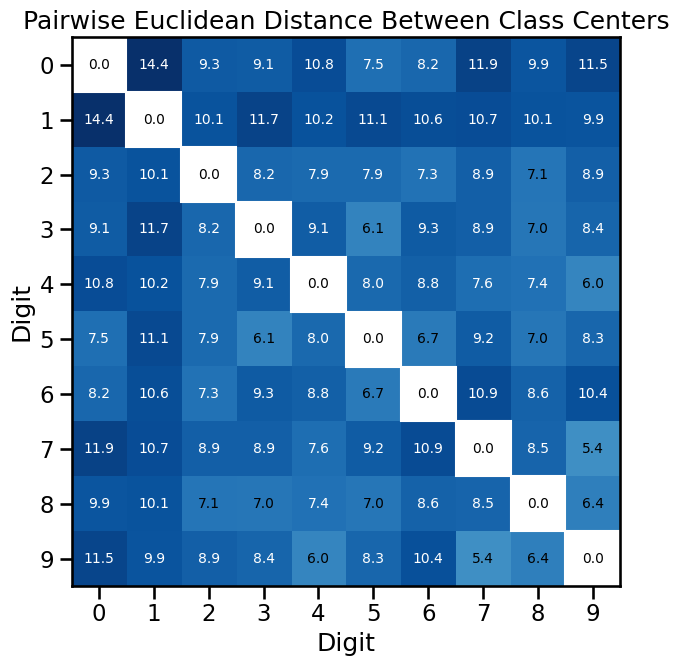

Closest 10 class-center pairs:
7 vs 9 — dist=5.43
4 vs 9 — dist=6.01
3 vs 5 — dist=6.12
8 vs 9 — dist=6.40
5 vs 6 — dist=6.70
5 vs 8 — dist=6.97
3 vs 8 — dist=7.02
2 vs 8 — dist=7.08
2 vs 6 — dist=7.33
4 vs 8 — dist=7.38


In [57]:
center_distances = cdist(centers_matrix, centers_matrix, metric="euclidean")

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(center_distances, cmap='Blues', norm=LogNorm(vmin=1, vmax=center_distances.max()))
ax.set_title("Pairwise Euclidean Distance Between Class Centers")
ax.set_xlabel("Digit")
ax.set_ylabel("Digit")
ax.set_xticks(range(len(labels_sorted)))
ax.set_yticks(range(len(labels_sorted)))
ax.set_xticklabels(labels_sorted)
ax.set_yticklabels(labels_sorted)
annotate_heatmap(ax, center_distances, fmt=".1f")
plt.tight_layout()
plt.show()

# List the 10 closest class pairs
pairs = [(i, j, center_distances[i, j])
         for i in range(len(labels_sorted))
         for j in range(i+1, len(labels_sorted))]
pairs_sorted = sorted(pairs, key=lambda x: x[2])

print("Closest 10 class-center pairs:")
for i, (a, b, d) in enumerate(pairs_sorted[:10], 1):
    print(f"{labels_sorted[a]} vs {labels_sorted[b]} — dist={d:.2f}")

## 4) 2D visualizations: PCA, t-SNE, UMAP

We visualize the training set with three projections:
- PCA: linear projection that preserves global variance structure
- t-SNE: emphasizes local neighborhoods and cluster separation
- UMAP: manifold learning that balances local and global structure

All plots color points by digit label and use fixed random seeds for reproducibility.


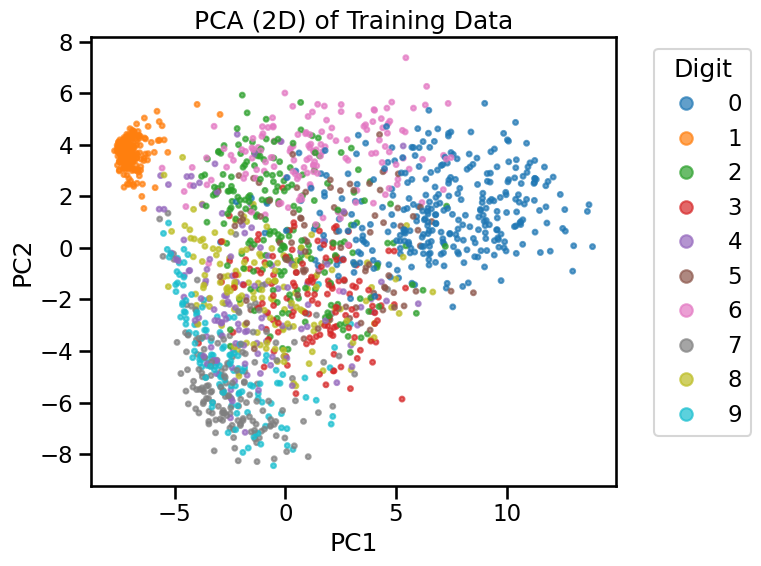

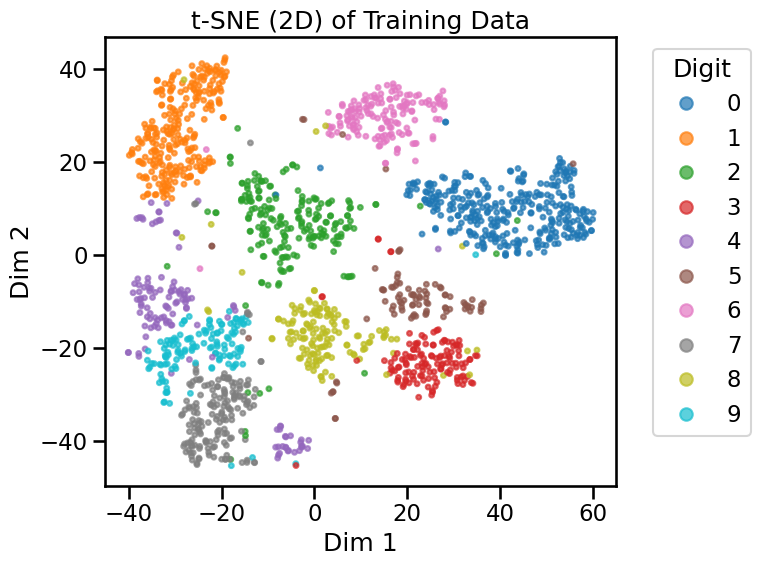

c:\Users\matis\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


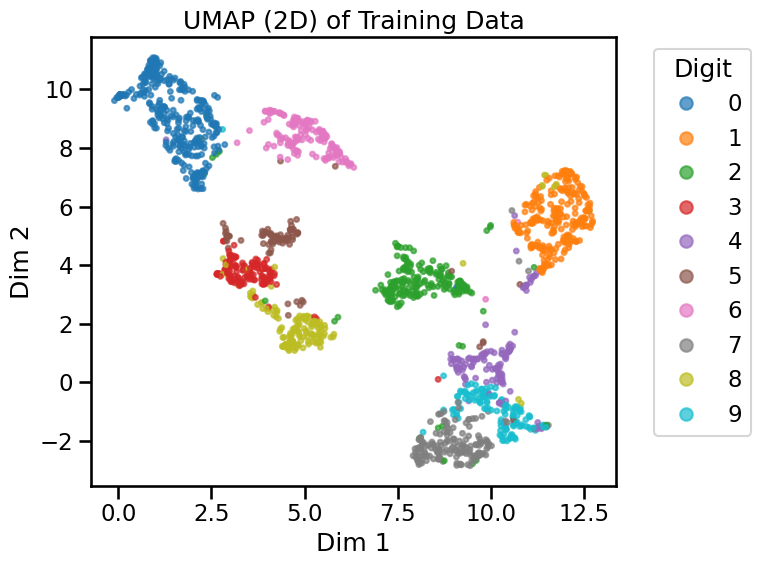

In [42]:
pca = PCA(n_components=2, random_state=123)
train_in_pca = pca.fit_transform(train_in)

plt.figure()
sc = plt.scatter(train_in_pca[:, 0], train_in_pca[:, 1],
                 c=train_out.values, cmap="tab10", alpha=0.7, s=12)
handles, _ = sc.legend_elements()
plt.legend(handles, [str(d) for d in range(10)], title="Digit",
           bbox_to_anchor=(1.05, 1), loc="upper left", ncols=1)
plt.title("PCA (2D) of Training Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=123, init="pca", learning_rate="auto")
train_in_tsne = tsne.fit_transform(train_in)

plt.figure()
sc = plt.scatter(train_in_tsne[:, 0], train_in_tsne[:, 1],
                 c=train_out.values, cmap="tab10", alpha=0.7, s=12)
handles, _ = sc.legend_elements()
plt.legend(handles, [str(d) for d in range(10)], title="Digit",
           bbox_to_anchor=(1.05, 1), loc="upper left", ncols=1)
plt.title("t-SNE (2D) of Training Data")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

umap_reducer = umap.UMAP(n_components=2, random_state=123)
train_in_umap = umap_reducer.fit_transform(train_in)

plt.figure()
sc = plt.scatter(train_in_umap[:, 0], train_in_umap[:, 1],
                 c=train_out.values, cmap="tab10", alpha=0.7, s=12)
handles, _ = sc.legend_elements()
plt.legend(handles, [str(d) for d in range(10)], title="Digit",
           bbox_to_anchor=(1.05, 1), loc="upper left", ncols=1)
plt.title("UMAP (2D) of Training Data")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## 5) Compare classifiers: Nearest-Mean vs k-NN (k=3)

We train k-NN on the training set and evaluate both methods on train and test.  
We report overall accuracy and show matrices (each row sums to 1).


k-NN (k=3) accuracy — Train: 0.979 | Test: 0.914
Nearest-Mean accuracy — Train: 0.864 | Test: 0.804


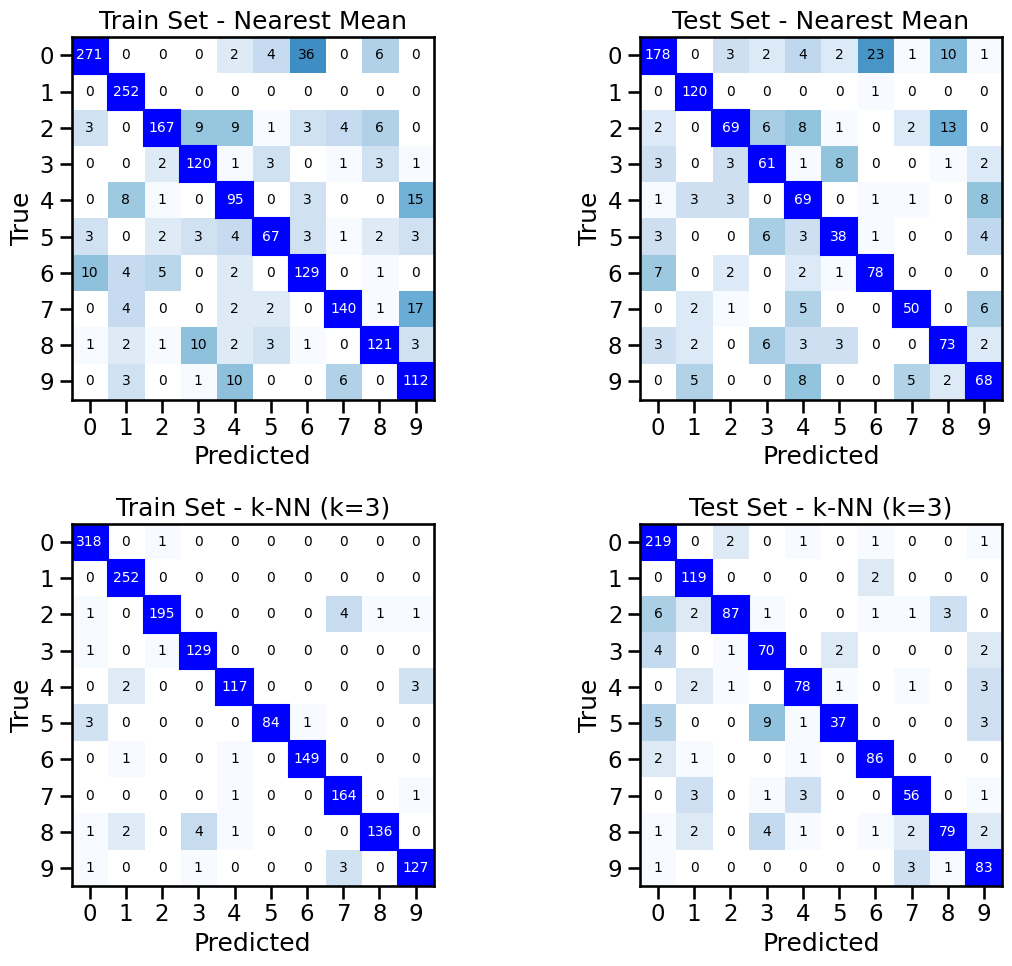

In [55]:

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_in.values, train_out.values)
train_pred_knn = knn.predict(train_in.values)
test_pred_knn  = knn.predict(test_in.values)

train_acc_knn = np.mean(train_pred_knn == train_out.values)
test_acc_knn  = np.mean(test_pred_knn  == test_out.values)

print(f"k-NN (k=3) accuracy — Train: {train_acc_knn:.3f} | Test: {test_acc_knn:.3f}")
print(f"Nearest-Mean accuracy — Train: {train_acc_mean:.3f} | Test: {test_acc_mean:.3f}")


cm_train_mean = confusion_matrix(train_out.values, train_pred_mean, labels=range(10))
cm_test_mean  = confusion_matrix(test_out.values,  test_pred_mean,  labels=range(10))
cm_train_knn  = confusion_matrix(train_out.values, train_pred_knn,  labels=range(10))
cm_test_knn   = confusion_matrix(test_out.values,  test_pred_knn,   labels=range(10))

cm_train_mean_norm = confusion_matrix(train_out.values, train_pred_mean, labels=range(10), normalize="true")
cm_test_mean_norm  = confusion_matrix(test_out.values,  test_pred_mean,  labels=range(10), normalize="true")
cm_train_knn_norm  = confusion_matrix(train_out.values, train_pred_knn,  labels=range(10), normalize="true")
cm_test_knn_norm   = confusion_matrix(test_out.values,  test_pred_knn,   labels=range(10), normalize="true")


fig, axs = plt.subplots(2, 2, figsize=(12,10))

for ax in axs.flat:
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(0, 10))
    ax.set_yticklabels(range(0, 10))

im0 = axs[0,0].imshow(cm_train_mean, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_train_mean.max()))
axs[0,0].set_title("Train Set - Nearest Mean")
axs[0,0].set_xlabel("Predicted")
axs[0,0].set_ylabel("True")
annotate_heatmap(axs[0,0], cm_train_mean)

im1 = axs[0,1].imshow(cm_test_mean, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_test_mean.max()))
axs[0,1].set_title("Test Set - Nearest Mean")
axs[0,1].set_xlabel("Predicted")
axs[0,1].set_ylabel("True")
annotate_heatmap(axs[0,1], cm_test_mean)

im2 = axs[1,0].imshow(cm_train_knn, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_train_knn.max()))
axs[1,0].set_title("Train Set - k-NN (k=3)")
axs[1,0].set_xlabel("Predicted")
axs[1,0].set_ylabel("True")
annotate_heatmap(axs[1,0], cm_train_knn)

im3 = axs[1,1].imshow(cm_test_knn, cmap='Blues', norm=LogNorm(vmin=1, vmax=cm_test_knn.max()))
axs[1,1].set_title("Test Set - k-NN (k=3)")
axs[1,1].set_xlabel("Predicted")
axs[1,1].set_ylabel("True")
annotate_heatmap(axs[1,1], cm_test_knn)

plt.tight_layout()
plt.show()
